In [ ]:
Notes on getting data:
    -https://www.premierleague.com/match/59065 gives all information (goals, yellow/red cards, fouls)
    -https://www.football-data.org/ is good API, but need to pay for yellow cards (have emailed asking for access)
    -https://github.com/openfootball/england/tree/master/2020-21 is good, but just has goals  
    -https://elenasport.io/ Looks promising, need to sign up. Have signed up, contains yellow cards. Think shall go with this.   

In [452]:
import requests
import http.client 
import json
import pprint
import pandas as pd
import numpy as np
from scipy.stats import t
from datetime import datetime
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [896]:
#Reading in API key
file = open("rapid_api_key.txt")
rapid_api_key = file.read().strip("\n")
#Now saved as global variable, so can be used inside functions

In [894]:
#Start of making functions

#Function to retrieve json object from API endpoint
def makeRequest(url, querystring = {}):
    
    headers = {
    'x-rapidapi-key': rapid_api_key,
    'x-rapidapi-host': "elenasport-io1.p.rapidapi.com"
    }
    
    response = requests.request("GET", url, headers=headers, params = querystring)
    if(response.status_code == 404):
        print("Connection not made, returning nothing")
        return 0
    if(response.status_code == 200):      
        print(f"Response code is {response.status_code}, all is well")
    response_data_json = response.json()
    return response_data_json

In [ ]:
#Order of getting infomration from ElenaSport.io

# Country ID
# League ID
# Seasons by League ID
# Fixtures by Season ID
# stats by Fixture ID

In [848]:
# response_data_json = response.json()
# pprint.pprint(response_data_json)

def getCountryIDfromCountryName(country_name):
    url = "https://elenasport-io1.p.rapidapi.com/v2/countries"
    query_string = {"name":"Eng","page":"1"}
    response_data_json = makeRequest(url, query_string)
    
    for keys in response_data_json['data']:
        print(keys['name'])
        if(keys['name'] == country_name):
            country_id = keys['id']
            print(f"Country id for {country_name} is {country_id}")
            return country_id

In [895]:
country_id = getCountryIDfromCountryName('England')

Response code is 200, all is well
England
Country id for England is 27


In [255]:
def getLeaguesIDfromCountryID(leagues_name, country_id):
    url =  f"https://elenasport-io1.p.rapidapi.com/v2/countries/{country_id}/leagues"
    print(f"Leagues url is {url}")
    leagues_data_json = makeRequest(url)
    
    for key in leagues_data_json['data']:
        print(key['name'])
        print(leagues_name)
        if(str(key['name']) == str(leagues_name)):
            print(f"{leagues_name} id is {key['id']}")
            return key['id']
        

In [256]:
leagues_id = getLeaguesIDfromCountryID('Premier League', 27)
leagues_id

Leagues url is https://elenasport-io1.p.rapidapi.com/v2/countries/27/leagues
FA Cup
Premier League
Premier League
Premier League
Premier League id is 234


234

In [192]:
def getLeagueIDfromLeagues(leagueName, leagues_json):
    #Takes in JSON file
    for key in leagues_json['data']:
        print(key['name'])
        print(leagueName)
        if(str(key['name']) == str(leagueName)):
            
#         if(leagueName in key):
            print(f"{leagueName} id is {key['id']}")
            return key['id']
        
    
league_id = getLeagueIDfromLeagues('Premier League', leagues_data_json)    
    

FA Cup
Premier League
Premier League
Premier League
Premier League id is 234


In [257]:
def getSeasonIDfromLeagueID(season_name, league_id):
    url = f"https://elenasport-io1.p.rapidapi.com/v2/leagues/{leagueID}/seasons"
    print(f"Season url is {url}")
    league_data_json = makeRequest(url)
    for key in league_json['data']:
        print(key['leagueName'])
        print(season_name)
        if(str(key['leagueName']) == str(season_name)):
            print(f"{season_name} id is {key['id']}")
            return key['id']
    

In [438]:
season_id = getSeasonIDfromLeagueID("Premier League - 2019/2020", league_id)

Season url is https://elenasport-io1.p.rapidapi.com/v2/leagues/234/seasons
Premier League - 2020/2021
Premier League - 2019/2020
Premier League - 2019/2020
Premier League - 2019/2020
Premier League - 2019/2020 id is 96


In [884]:
def getFixturesfromSeasonID(season_id):
    print(f"Getting fixtures from season ID {season_id}")
    url = f"https://elenasport-io1.p.rapidapi.com/v2/seasons/{season_id}/fixtures"
    print(f"Url is {url}")
    fixtureData = []
    
    for page_no in range(1, 20): 
        print(f"Getting data from page {page_no}")
        querystring = {"page":str(page_no),"expand":"stats,events"}
        season_json = makeRequest(url, querystring)

        for fixture in season_json['data']:
#             print(f"Date: {fixture['date']}")
            fixtureData.append(getFixtureStats(fixture))

    return fixtureData

In [885]:
def getFixtureStats(fixture):
    print(f"Date: {fixture['date']}")
    print(f"Score: {fixture['homeName']} {fixture['team_home_90min_goals']} - {fixture['team_away_90min_goals']} {fixture['awayName']}")

    #Getting number of y_cards
    y_card_sum = 0
    try:
        for event in fixture['expand']['events']:
            if (event['type'] == 'y_card'):
#                 print(f"{event['type']} at {event['elapsed']} minutes")
                y_card_sum = y_card_sum + 1 
    except:
        print("No events found")
        
    #Getting number of r_cards
    r_card_sum = 0
    try:
        for event in fixture['expand']['events']:
            if (event['type'] == 'r_card'):
#                 print(f"{event['type']} at {event['elapsed']} minutes")
                r_card_sum = r_card_sum + 1 
    except:
        print("No events found")
        
        
    print(f"y card sum = {y_card_sum}")
    print(f"r card sum = {r_card_sum}")
    
    return [datetime.strptime(fixture['date'], '%Y-%m-%d %H:%M:%S'), fixture['homeName'], fixture['awayName'], fixture['team_home_90min_goals'], fixture['team_away_90min_goals'], r_card_sum, y_card_sum]

In [886]:
fixtureData = getFixturesfromSeasonID(season_id)

Getting fixtures from season ID 96
Url is https://elenasport-io1.p.rapidapi.com/v2/seasons/96/fixtures
Getting data from page 1
Response code is 200, all is well
Date: 2020-06-21 13:00:00
Score: Newcastle United 3 - 0 Sheffield United
y card sum = 3
r card sum = 0
Date: 2020-06-27 11:30:00
Score: Aston Villa 0 - 1 Wolverhampton Wanderers
y card sum = 2
r card sum = 0
Date: 2020-07-01 19:15:00
Score: West Ham United 3 - 2 Chelsea
y card sum = 3
r card sum = 0
Date: 2020-07-11 11:30:00
Score: Watford 2 - 1 Newcastle United
y card sum = 5
r card sum = 0
Date: 2020-07-11 14:00:00
Score: Liverpool 1 - 1 Burnley
y card sum = 3
r card sum = 0
Date: 2020-07-11 16:30:00
Score: Sheffield United 3 - 0 Chelsea
y card sum = 1
r card sum = 0
Date: 2020-07-11 19:00:00
Score: Brighton & Hove Albion 0 - 5 Manchester City
y card sum = 1
r card sum = 0
Date: 2020-07-12 11:00:00
Score: Wolverhampton Wanderers 3 - 0 Everton
y card sum = 2
r card sum = 0
Date: 2020-07-12 13:15:00
Score: Aston Villa 2 - 0 Cr

Response code is 200, all is well
Date: 2020-01-18 15:00:00
Score: Brighton & Hove Albion 1 - 1 Aston Villa
y card sum = 5
r card sum = 0
Date: 2020-01-18 15:00:00
Score: Manchester City 2 - 2 Crystal Palace
y card sum = 3
r card sum = 0
Date: 2020-01-18 15:00:00
Score: Southampton 2 - 3 Wolverhampton Wanderers
y card sum = 2
r card sum = 0
Date: 2020-01-18 17:30:00
Score: Newcastle United 1 - 0 Chelsea
y card sum = 2
r card sum = 0
Date: 2020-01-19 14:00:00
Score: Burnley 2 - 1 Leicester City
y card sum = 1
r card sum = 0
Date: 2020-01-19 16:30:00
Score: Liverpool 2 - 0 Manchester United
y card sum = 4
r card sum = 0
Date: 2020-01-21 19:30:00
Score: AFC Bournemouth 3 - 1 Brighton & Hove Albion
y card sum = 2
r card sum = 0
Date: 2020-01-21 19:30:00
Score: Aston Villa 2 - 1 Watford
y card sum = 4
r card sum = 0
Date: 2020-01-21 19:30:00
Score: Everton 2 - 2 Newcastle United
y card sum = 2
r card sum = 0
Date: 2020-01-21 19:30:00
Score: Sheffield United 0 - 1 Manchester City
y card sum 

Response code is 200, all is well
Date: 2019-10-06 13:00:00
Score: Manchester City 0 - 2 Wolverhampton Wanderers
y card sum = 7
r card sum = 0
Date: 2019-10-06 15:30:00
Score: Newcastle United 1 - 0 Manchester United
y card sum = 6
r card sum = 0
Date: 2019-10-20 15:30:00
Score: Manchester United 1 - 1 Liverpool
y card sum = 1
r card sum = 0
Date: 2019-10-21 19:00:00
Score: Sheffield United 1 - 0 Arsenal
y card sum = 8
r card sum = 0
Date: 2019-10-25 19:00:00
Score: Southampton 0 - 9 Leicester City
y card sum = 0
r card sum = 1
Date: 2019-10-26 11:30:00
Score: Manchester City 3 - 0 Aston Villa
y card sum = 3
r card sum = 0
Date: 2019-10-26 14:00:00
Score: Brighton & Hove Albion 3 - 2 Everton
y card sum = 3
r card sum = 0
Date: 2019-10-26 14:00:00
Score: Watford 0 - 0 AFC Bournemouth
y card sum = 8
r card sum = 0
Date: 2019-10-26 14:00:00
Score: West Ham United 1 - 1 Sheffield United
y card sum = 4
r card sum = 0
Date: 2019-10-26 16:30:00
Score: Burnley 2 - 4 Chelsea
y card sum = 5
r ca

Response code is 200, all is well
Date: 2019-08-10 11:30:00
Score: West Ham United 0 - 5 Manchester City
y card sum = 4
r card sum = 0
Date: 2019-08-10 14:00:00
Score: AFC Bournemouth 1 - 1 Sheffield United
y card sum = 3
r card sum = 0
Date: 2019-08-10 14:00:00
Score: Crystal Palace 0 - 0 Everton
y card sum = 4
r card sum = 0
Date: 2019-08-10 14:00:00
Score: Watford 0 - 3 Brighton & Hove Albion
y card sum = 1
r card sum = 0
Date: 2019-08-11 13:00:00
Score: Leicester City 0 - 0 Wolverhampton Wanderers
y card sum = 2
r card sum = 0
Date: 2019-08-17 14:00:00
Score: Norwich City 3 - 1 Newcastle United
y card sum = 4
r card sum = 0
Date: 2019-08-19 19:00:00
Score: Wolverhampton Wanderers 1 - 1 Manchester United
y card sum = 4
r card sum = 0
Date: 2019-08-25 13:00:00
Score: AFC Bournemouth 1 - 3 Manchester City
y card sum = 4
r card sum = 0
Date: 2019-08-25 15:30:00
Score: Wolverhampton Wanderers 1 - 1 Burnley
y card sum = 2
r card sum = 0
Date: 2019-09-01 13:00:00
Score: Everton 3 - 2 Wolv

In [887]:
#Reading in fixture data to dataframe
columns = ['Date', 'Home Team', 'Away Team', 'Away Goals', 'Home Goals', 'Red Cards', 'Yellow cards']
fixture_df = pd.DataFrame(data=fixtureData, columns = columns)
fixture_df.tail()

,Date,Home Team,Away Team,Away Goals,Home Goals,Red Cards,Yellow cards
361,2019-12-07 15:00:00,AFC Bournemouth,Liverpool,0,3,0,1
362,2019-12-07 15:00:00,Tottenham Hotspur,Burnley,5,0,0,2
363,2019-12-07 15:00:00,Watford,Crystal Palace,0,0,0,5
364,2019-12-07 17:30:00,Manchester City,Manchester United,1,2,0,5
365,2019-12-08 14:00:00,Aston Villa,Leicester City,1,4,0,8


In [462]:
type(fixture_df.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [790]:
def split_data_by_date(df, date):
    date = datetime.strptime(date, '%Y-%m-%d')
    df1 = df[(df['Date'] > date) & (df['Yellow cards'] < 7)]
    df2 = df[(df['Date'] < date) & (df['Yellow cards'] < 7)]
    
#     df1 = df.sample(int(1 * len(df)), replace = False)
#     df2 = df.sample(int(1 * len(df)), replace = False)
    
    print(f"Fixtures after {date} =  {len(df1)}")
    print(f"Fixtures before {date} =  {len(df2)}")
    
    return df1, df2
    

In [853]:
fixture_df_AC, fixture_df_BC = split_data_by_date(fixture_df, '2020-05-01')

Fixtures after 2020-05-01 00:00:00 =  86
Fixtures before 2020-05-01 00:00:00 =  254


Text(0.5, 0, 'Yellow Cards per game')

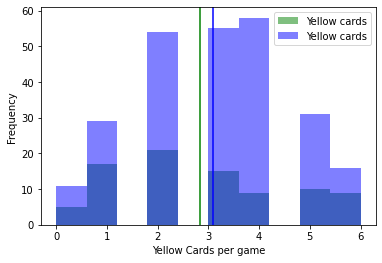

In [855]:
fixture_df_AC['Yellow cards'].plot.hist(alpha=0.5, color='green')
fixture_df_BC['Yellow cards'].plot.hist(alpha=0.5, color='blue')
plt.axvline(fixture_df_AC['Yellow cards'].mean(), color='green')
plt.axvline(fixture_df_BC['Yellow cards'].mean(), color='blue')
plt.legend()
plt.xlabel("Yellow Cards per game")

Average yellow cards per game has changed by -0.253


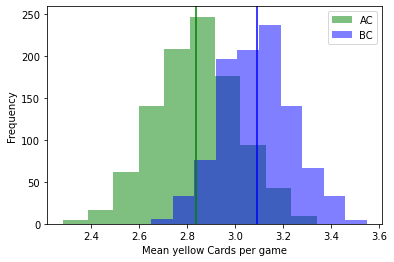

In [856]:
bootstrapped_fixtures_fixture_df_AC_yellow_cards = pd.DataFrame({'Mean Yellow cards' : [fixture_df_AC['Yellow cards'].sample(len(bootstrapped_fixtures_fixture_df_AC_yellow_cards), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_yellow_cards = pd.DataFrame({'Mean Yellow cards' : [fixture_df_BC['Yellow cards'].sample(len(bootstrapped_fixtures_fixture_df_BC_yellow_cards), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_AC_yellow_cards['Mean Yellow cards'].plot.hist(alpha=0.5, color='green', label= "AC")
bootstrapped_fixtures_fixture_df_BC_yellow_cards['Mean Yellow cards'].plot.hist(alpha=0.5, color='blue', label= "BC")
plt.axvline(fixture_df_AC['Yellow cards'].mean(), color='green')
plt.axvline(fixture_df_BC['Yellow cards'].mean(), color='blue')
plt.legend()
plt.xlabel("Mean yellow Cards per game")
print("Average yellow cards per game has changed by {:.3f}".format(fixture_df_AC['Yellow cards'].mean() - fixture_df_BC['Yellow cards'].mean()))

In [857]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_yellow_cards['Mean Yellow cards'], bootstrapped_fixtures_fixture_df_BC_yellow_cards['Mean Yellow cards'])
scipy.stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_yellow_cards['Mean Yellow cards'], bootstrapped_fixtures_fixture_df_BC_yellow_cards['Mean Yellow cards'])

Means: 2.837440000000002, 3.085340000000004
Stds: 0.17234892094396917, 0.14873064648956924
Counts: 1000, 1000
Std errors: 0.005450151424552398, 0.0047032760077636545
t_stat is -34.435552608558304
Number of deg_f are 1998
Critical value is 1.6456166300576656
p value is 0.00000
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-34.435552608558055, pvalue=2.0737311543700317e-204)

In [858]:
#Adding in sum of goals column
fixture_df['Sum Goals'] = fixture_df['Away Goals'] + fixture_df['Home Goals']

In [859]:
fixture_df_AC, fixture_df_BC = split_data_by_date(fixture_df, '2020-05-01')
bootstrapped_fixtures_fixture_df_AC_goals = pd.DataFrame({'Mean Goals' : [fixture_df_AC['Sum Goals'].sample(len(fixture_df_AC['Sum Goals']), replace=True).mean() for i in range(100000)]})
bootstrapped_fixtures_fixture_df_BC_goals = pd.DataFrame({'Mean Goals' : [fixture_df_BC['Sum Goals'].sample(len(fixture_df_BC['Sum Goals']), replace=True).mean() for i in range(100000)]})

Fixtures after 2020-05-01 00:00:00 =  86
Fixtures before 2020-05-01 00:00:00 =  254


Average goals per game has changed by -0.086


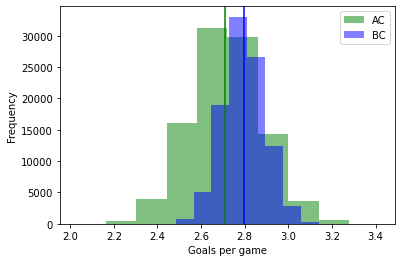

In [860]:
bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'].plot.hist(alpha=0.5, color='green', label= "AC")
bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'].plot.hist(alpha=0.5, color='blue', label= "BC")
plt.axvline(fixture_df_AC['Sum Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Sum Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Goals per game")
print("Average goals per game has changed by {:.3f}".format(fixture_df_AC['Sum Goals'].mean() - fixture_df_BC['Sum Goals'].mean()))

In [861]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'], bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'])
scipy.stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'], bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'])

Means: 2.7100280232557217, 2.7953683070863318
Stds: 0.16313058503893382, 0.09522374015553381
Counts: 100000, 100000
Std errors: 0.0005158642047588184, 0.0003011239062115232
t_stat is -142.8719073261758
Number of deg_f are 199998
Critical value is 1.6448612459089054
p value is 0.00000
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-142.87190732650475, pvalue=0.0)

In [862]:
#Testing for home and away goals
bootstrapped_fixtures_fixture_df_AC_home_goals = pd.DataFrame({'Mean Home Goals' : [fixture_df_AC['Home Goals'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_home_goals = pd.DataFrame({'Mean Home Goals' : [fixture_df_BC['Home Goals'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})

Average home goals per game has changed by -0.078


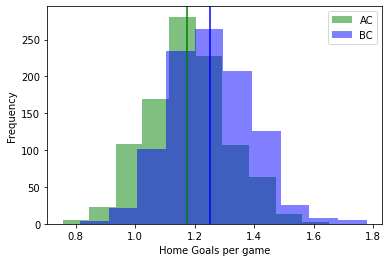

In [873]:
bootstrapped_fixtures_fixture_df_AC_home_goals['Mean Home Goals'].plot.hist(alpha=0.5, color='green', label= "AC")
bootstrapped_fixtures_fixture_df_BC_home_goals['Mean Home Goals'].plot.hist(alpha=0.5, color='blue', label= "BC")
plt.axvline(fixture_df_AC['Home Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Home Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Home Goals per game")
print("Average home goals per game has changed by {:.3f}".format(fixture_df_AC['Home Goals'].mean() - fixture_df_BC['Home Goals'].mean()))

In [874]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'], bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'])
scipy.stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'], bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'])

Means: 2.7100280232557217, 2.7953683070863318
Stds: 0.16313058503893382, 0.09522374015553381
Counts: 100000, 100000
Std errors: 0.0005158642047588184, 0.0003011239062115232
t_stat is -142.8719073261758
Number of deg_f are 199998
Critical value is 1.6448612459089054
p value is 0.00000
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-142.87190732650475, pvalue=0.0)

In [875]:
bootstrapped_fixtures_fixture_df_AC_away_goals = pd.DataFrame({'Mean Away Goals' : [fixture_df_AC['Away Goals'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_away_goals = pd.DataFrame({'Mean Away Goals' : [fixture_df_BC['Away Goals'].sample(len(fixture_df_BC), replace=True).mean() for i in range(1000)]})

Average away goals per game has changed by -0.008


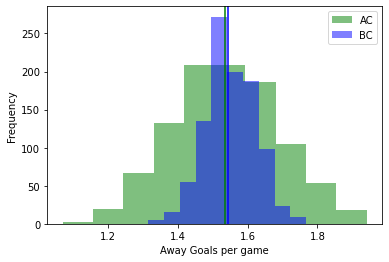

In [877]:
bootstrapped_fixtures_fixture_df_AC_away_goals['Mean Away Goals'].plot.hist(alpha=0.5, color='green', label= "AC")
bootstrapped_fixtures_fixture_df_BC_away_goals['Mean Away Goals'].plot.hist(alpha=0.5, color='blue', label= "BC")
plt.axvline(fixture_df_AC['Away Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Away Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Away Goals per game")
print("Average away goals per game has changed by {:.3f}".format(fixture_df_AC['Away Goals'].mean() - fixture_df_BC['Away Goals'].mean()))

In [878]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_away_goals['Mean Away Goals'], bootstrapped_fixtures_fixture_df_BC_away_goals['Mean Away Goals'])
scipy.stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_away_goals['Mean Away Goals'], bootstrapped_fixtures_fixture_df_BC_away_goals['Mean Away Goals'])

Means: 1.5355581395348834, 1.5495000000000003
Stds: 0.15105425145923365, 0.07142146468651545
Counts: 1000, 1000
Std errors: 0.004776754848629914, 0.002258545022346726
t_stat is -2.6386110203347157
Number of deg_f are 1998
Critical value is 1.6456166300576656
p value is 0.00839
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-2.6386110203345936, pvalue=0.008389295605289747)

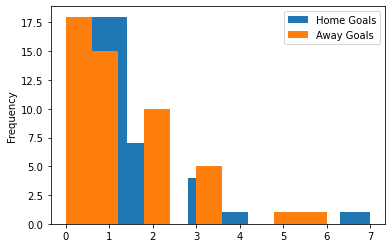

In [273]:
fixture_df['Home Goals'].plot.hist()
fixture_df['Away Goals'].plot.hist()
plt.legend()

In [272]:
len(fixture_df)

50

0     1
1     4
2     2
3     2
4     0
5     2
6     2
7     1
8     1
9     0
10    5
11    1
12    0
13    0
14    1
15    3
16    3
17    2
18    6
19    4
20    0
21    3
22    4
23    1
24    0
25    3
26    2
27    2
28    7
29    2
30    0
31    2
32    3
33    0
34    5
35    7
36    1
37    3
38    2
39    2
40    2
41    8
42    3
43    3
44    3
45    4
46    3
47    0
48    4
49    2
Name: Sum Goals, dtype: int64
2.42


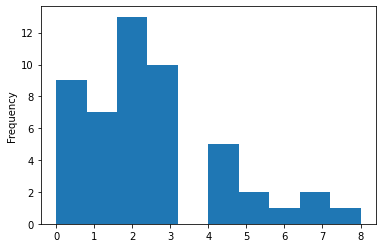

In [282]:
#Adding in sum of goals column
fixture_df['Sum Goals'] = fixture_df['Away Goals'] + fixture_df['Home Goals']
fixture_df['Sum Goals'].plot.hist()
print(fixture_df['Sum Goals'])
print(fixture_df['Sum Goals'].mean())

In [283]:
#Attempting bootstrapping goals to try to get normal distribution
fixture_df['Sum Goals'].value_counts(normalize=True)

2    0.26
3    0.20
0    0.18
1    0.14
4    0.10
7    0.04
5    0.04
8    0.02
6    0.02
Name: Sum Goals, dtype: float64

In [301]:
#Sample with replacement
bootstrapped_fixtures_df = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean() for i in range(10000)]})

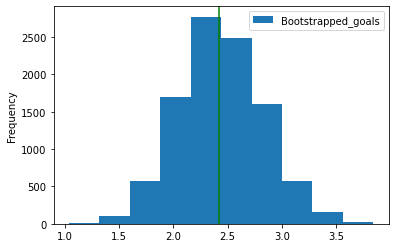

In [304]:
bootstrapped_fixtures_df.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

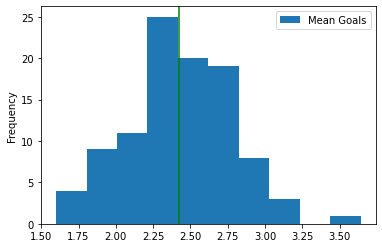

In [305]:
bootstrapped_fixtures_df_1 = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean() for i in range(100)]})
bootstrapped_fixtures_df_1.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

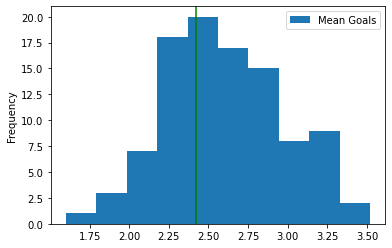

In [391]:
bootstrapped_fixtures_df_2 = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean()+0.2 for i in range(100)]})
bootstrapped_fixtures_df_2.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

In [412]:
def calculate_t_statistic(data1, data2, alpha = 0.05):
    #Calculate t-test
    mean1, mean2 = data1.mean(), data2.mean()
    print(f"Means: {mean1}, {mean2}")
    std1, std2 = data1.std(), data2.std()
    print(f"Stds: {std1}, {std2}")
    N1, N2 = len(data1), len(data2)
    print(f"Counts: {N1}, {N2}")
    std_err_1, std_err_2 = std1/np.sqrt(N1), std2/np.sqrt(N2)
    print(f"Std errors: {std_err_1}, {std_err_2}")
    t_stat = (mean1 - mean2)/np.sqrt(std_err_1 * std_err_1 + std_err_2 * std_err_2)
    print(f"t_stat is {t_stat}")
    
    #degrees of freedom
    deg_f = N1 + N2 - 2
    print(f"Number of deg_f are {deg_f}")
    
    #Calculating the critical value
    crit_val = t.ppf(1.0 - alpha, deg_f)
    print(f"Critical value is {crit_val}")
    
    p_val = (1.0 - t.cdf(abs(t_stat), df = deg_f)) * 2.0
    print(f"p value is {p_val:.5f}")
    
    if(p_val < alpha):
        print("Statistically significant difference, can reject null hypothesis")
    else:
        print("No statistically significant difference, cannot reject null hypothesis")
        
    if(crit_val < abs(t_stat)):
        print("Statistically significant difference, can reject null hypothesis")
    else:
        print("No statistically significant difference, cannot reject null hypothesis")
        

In [413]:
calculate_t_statistic(bootstrapped_fixtures_df_1['Mean Goals'], bootstrapped_fixtures_df_2['Mean Goals'])

Means: 2.4316000000000013, 2.603199999999999
Stds: 0.3593617237336894, 0.377495414381139
Counts: 100, 100
Std errors: 0.03593617237336894, 0.0377495414381139
t_stat is -3.2924373196038745
Number of deg_f are 198
Critical value is 1.6525857836172075
p value is 0.00118
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


In [414]:
#Validating calculations using scipy stats t-test
scipy.stats.ttest_ind(bootstrapped_fixtures_df_1['Mean Goals'], bootstrapped_fixtures_df_2['Mean Goals'])

Ttest_indResult(statistic=-3.2924373196039425, pvalue=0.001176232992571106)

In [411]:
#Testing using shaking hands example
coffee_array = np.array([34, 52, 26, 47, 42, 37, 40])
soda_array = np.array([39, 57, 68, 74, 49, 57])
calculate_t_statistic(coffee_array, soda_array)

Means: 39.714285714285715, 57.333333333333336
Stds: 7.90504876128967, 11.527744310527055
Counts: 7, 6
Std errors: 2.9878275891730945, 4.706181907677194
t_stat is -3.160639991435542
Number of deg_f are 11
Critical value is 1.7958848187036691
p value is 0.00907
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis
